# Cut-edges possibilities
This notebook summarizes the possible ways in which we create cut-edges. 

In [1]:
import spot
from spot.seminator import seminator
from spot.jupyter import display_inline
import buddy
spot.setup(show_default=".n")

We first create an example automaton using HOA.

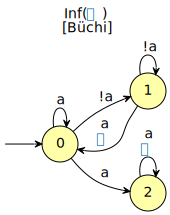

In [2]:
aut1 = spot.automaton("""HOA: v1 
States: 3 Start: 0 AP: 1 "a"
Acceptance: 1 Inf(0) --BODY--
State: 0 [0] 0 [!0] 1 [0] 2
State: 1 [!0] 1 [0] 0 {0}
State: 2 [0] 2 {0} --END--"""); display(aut1)

The following semi-deterministic automata demonstrate three strategies to "cut", i.e., which transitions of the non-deterministic component will be duplicated to jump into the deterministic part.
- the default strategy is to cut for each accepting transition (in the Büchi case), or each transition labeled by the highest mark (in the generalized Büchi case), we know that at least one such transition exists on each accepting cycle.
- the cut-on-scc-entry strategy cuts on each transition that goes into an accepting SCC
- the cut-always strategy simply cuts on each transition 

In [3]:
def example(a, **opts):
    # note: the pure=True option disables all optimizations that are usually on by default
    default = seminator(a, highlight=True, pure=True, **opts)
    default.set_name("default")
    cutentry = seminator(a, highlight=True, pure=True, cut_on_scc_entry=True, **opts)
    cutentry.set_name("cut-on-scc-entry")
    cutalways = seminator(a, highlight=True, pure=True, cut_always=True, **opts)
    cutalways.set_name("cut-always")
    display_inline(default, cutentry, cutalways, per_row=3)
    
example(aut1, postprocess=False)

It is clear that each strategy adds more cut-transitions, but sometimes the regularity of the added transitions helps automata simplifications performed afterwards.  In this case, we observe it makes very little differences.

In [4]:
example(aut1, postprocess=True)

## powerset-on-cut
We build cut-edges for edges in the original automaton based on *cut-condition*. For an edge $e=(s,\alpha,p)$ that satisfies the cut-condition we build a cut-edge $\big(s,\alpha,({p},\emptyset,0)\big)$. The option `powerset-on-cut` changes the behaviour such that for $e$ we build rather the cut-edge $$ (s,\alpha,(R,B,0)) \qquad R = \delta(s,\alpha) \qquad B = \delta_0(s,\alpha)$$ where $\delta_0$ computes the successors reachable via edges marked by $0$. The idea is illustrated by the following example which is a case where it saves the state of the form $({p},\emptyset,0)$.

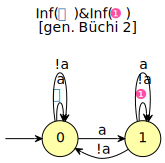

In [5]:
aut2 = spot.automaton("""HOA: v1 States: 2 Start: 0 
AP: 1 "a" Acceptance: 2 Inf(0)&Inf(1) --BODY-- 
State: 0 [0] 0 {0} [0] 1 [!0] 0 
State: 1 [!0] 1 {1} [!0] 0 [0] 1 --END--""")
display(aut2)

The unoptimized behaviour of seminator creates a 7-state automaton which is barely touched by the postprocessings of Spot (some non-determinism is removed on the initial state)

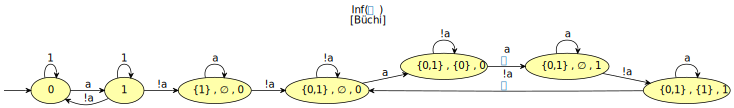

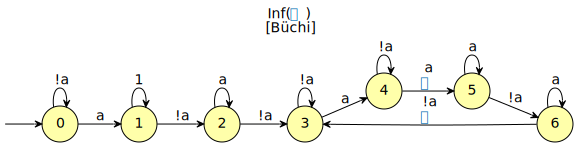

In [6]:
basic = seminator(aut2, pure=True, postprocess=False)
display(basic)
display(seminator(aut2, pure=True, postprocess=True))

The orange state below will be avoided by the proposed change. The target states of cut-edges always hold exactly 1 state and this state is the same as the source of the red cut-edge. The powerset-successor of the state is thus always computed and reached anyway, now from the breakpoint state. The proposed idea substitutes the red edge by the green edge which makes the orange state unreachable.

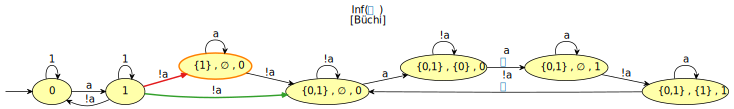

In [7]:
a_ap = buddy.bdd_ithvar(basic.register_ap('a'))
basic.new_edge(1,3,-a_ap)
basic.highlight_state(2,2).highlight_edge(5,5).highlight_edge(16,4)

In [8]:
power = seminator(aut2, pure=True, powerset_on_cut=True, postprocess=False)
power.set_name("powerset-on-cut")
psimp = seminator(aut2, pure=True, powerset_on_cut=True, postprocess=True)
psimp.set_name("powerset-on-cut simplified")
display_inline(power, psimp)